# Supplement B
# Drop Size Distribution retrieval


In the following, we introduce the use of the pyOptimalEstimation Python library using a radar-based drop-size distribution (DSD) retrieval as an example. 
Williams et al. (2014) suggested to parameterize a DSD using a scaling parameter $N_w$ as well as the raindrop mass spectrum mean diameter $D_m$ and its standard deviation $\sigma_m$.
Assuming that the DSD follows a gamma distribution, $\sigma_m$ is related to the shape parameter $\mu$ with 
\begin{equation} 
    \mu = (D_m/\sigma)^2 -4
\end{equation}
and we reconstruct the original DSD $N(D)$ as a function of maximum dimension $D$ with
\begin{equation}
    N(D) = N_w \frac{6}{256} \frac{(4+\mu)^{\mu+4}}{\Gamma(\mu+4)} \Big(\frac{D}{D_m}\Big)^{\mu} \exp \Big[ -(4+\mu) \frac{D}{D_m}\Big]
\end{equation}
using the normalization approach by Testud et al. (2001).

Williams et al. (2014) analyzed the correlations between $D_m$ and $\sigma_m$ in  detail and proposed to use a modified quantity $\sigma_m\!'$ defined with 
\begin{equation}
    \sigma_m\!' = \sigma_m D_m^{-1.36}
\end{equation}
in order to minimize the correlation to $D_m$. The three parameters required to estimate the DSD ($N_w$, $D_m$, and $\sigma_m\!'$) will form our state vector $\mathbf{x}$. 


A radar simulator will use $\mathbf{x}$ to estimate the measurement vector $\mathbf{y}$ consisting of the radar reflectivity factor ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$) with 
    \begin{equation}
    Z_e = 10 \times \log_{10} (10^{18} \times \sum_i N(D_i) \times \frac{\lambda^4}{|K_w|^2 \pi^5} \times \sigma(D_i) \times \Delta D ) 
    \end{equation}  
and
        \begin{equation}
V_d = \frac{\sum_i v(D_i) \times N(D_i) \times  \sigma(D_i) \times \Delta D}{\sum_i N(D_i) \times  \sigma(D_i) \times \Delta D}
    \end{equation}
where $i$ the index of the discrete DSD and $\sigma$ and $v$ are the functions to describe backscattering cross section and fall velocity, respectively. This means we have two measurements to derive three quantities of the state space, i.e. the problem is not unambiguous. 
In order to obtain the required prior data set, we use the Huntsville data set introduced in Williams et al. (2014) which consists of 18969 individual DSD distributions obtained at Huntsville, AL from December 2009 to October 2011. For every DSD, Williams et al. (2014) determined $N_w$, $D_m$, and $\sigma_m$ and we determine the a-priori assumption $\mathbf{x}_a$ and uncertainty (**S**$_a$) form the mean and the covariance of the data set, respectively. 

# Installation 
**You can skip the installation if you execute this online on binder**

In order to design a retrieval with pyOptimalEstimation, we need to install the library first with 
~~~~  
pip install pyOptimalEstimation
~~~~ 
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray libraries. For development, we used Numpy 1.18.1, Matplotlib 3.0.3, Scipy 1.2.1, Xarray 0.15.1, Pandas 1.0.3, Seaborn 0.9.0 and Uncertainties 3.0.3.

The radar simulations are done with the Passive and Active Microwave radiative TRAnsfer model (PAMTRA, Mech et al. 2020). Here, we use version 2 that is in active development, so we install a specific version with:
~~~~ 
pip install git+git://github.com/maahn/pamtra2.git@461b711ae366b791665687de5dec37abd7ab78f5
~~~~ 

# Preparation

We start with loading the required libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pn
import xarray as xr
import uncertainties.unumpy as unp
import seaborn as sns

import pamtra2

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')
abc = 'abcdefghijklmopqrstuvwxyz'

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/abc.py:85: FutureWarning: xarray subclass customProfile should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


We put some helper routines in a separate file which we load with 

In [2]:
import sys
sys.path.append('lib')
import supporting_routines

## State vector

In order to load the required prior data set, we load the Huntsville data set of Williams et al. (2014) from a netCDF file using xarray:

In [3]:
rainDat = xr.open_dataset('data/huntsville_parameters.nc')[[
    'Dm', 'Nw', 'Smprime'
]]

and add logarithmic variables with

In [4]:
rainDat['Nw_log10'] = np.log10(rainDat['Nw'])
rainDat['Dm_log10'] = np.log10(rainDat['Dm'])
rainDat['Smprime_log10'] = np.log10(rainDat['Smprime'])

rainDat

<xarray.Dataset>
Dimensions:        (time: 18969)
Coordinates:
  * time           (time) datetime64[ns] 2009-12-13T04:24:00 ... 2011-04-04T2...
Data variables:
    Dm             (time) float64 1.117 1.003 1.014 1.112 ... 1.377 1.475 1.476
    Nw             (time) float64 2.328e+03 4.55e+03 ... 3.125e+03 1.156e+03
    Smprime        (time) float64 0.3058 0.2524 0.2513 ... 0.3837 0.3386 0.3318
    Nw_log10       (time) float64 3.367 3.658 4.037 3.925 ... 3.581 3.495 3.063
    Dm_log10       (time) float64 0.04817 0.001143 0.00605 ... 0.1689 0.1692
    Smprime_log10  (time) float64 -0.5145 -0.598 -0.5999 ... -0.4703 -0.4791

We use 100 randomly chosen DSDs for the test data set and use the remaining DSDs for the training data set, i.e. to develop the retrieval.

In [5]:
nTest = 100

np.random.seed(10)
ii = np.arange(len(rainDat.time))
np.random.shuffle(ii)
testII, trainingII = ii[:nTest], ii[nTest:]

rainDat_test = rainDat.isel(time=testII)
rainDat_training = rainDat.isel(time=trainingII)

In order to asses the assumptions that the state variables follow a Gaussian distribution, we make quantile-quantile (QQ) plots. Comparison of the first and second column reveals that a logarithmic state vector $\mathbf{x}$ is much closer to a Gaussian distribution than the linear version. 

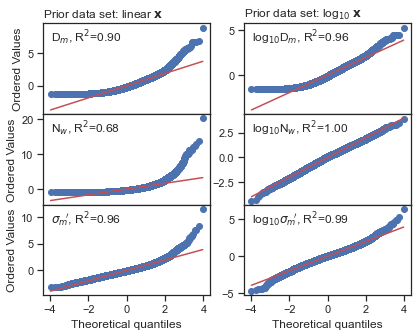

In [6]:
ncols = 2
fig, sps = plt.subplots(figsize=(6.6, 5), nrows=3, ncols=ncols, sharex=True)

sps = sps.reshape((3, ncols))

jj = 0

for kk in range(3):
    for ii, (x_name, x_vars) in enumerate([
        ('linear', ['Dm', 'Nw', 'Smprime']),
        ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
    ]):

        x_var = x_vars[kk]
        data = (rainDat_training[x_var] - np.mean(
            rainDat_training[x_var])) / np.std(rainDat_training[x_var])
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data, dist="norm", plot=sps[kk, ii], fit=True, rvalue=False)

        sps[kk, ii].set_title('')
        if kk == 0:
            sps[kk, ii].set_title(
                'Prior data set: %s $\mathbf{x}$' % (x_name),
                loc='left')

        sps[kk, ii].text(
            0.05,
            0.95,
            '%s, R$^2$=%.2f' % (
                supporting_routines.niceKeys[x_var], r**2
                #, x_mean, x_std
            ),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, ii].transAxes)

        if kk < 2:
            sps[kk, ii].set_xlabel("")
        if ii > 0:
            sps[kk, ii].set_ylabel("")
        jj += 1

fig.subplots_adjust(hspace=0)

The prior $\mathbf{x}_{a}$ and covariance **S**$_a$ of the state vector are estimated from the training data set. For convenience, we estimate it for the linear and logarithmic variables together and select the required quantities later. 

Dm                  1.461640
Nw               4054.575495
Smprime             0.299574
Nw_log10            3.436274
Dm_log10            0.153298
Smprime_log10      -0.530466
dtype: float64


<AxesSubplot:>

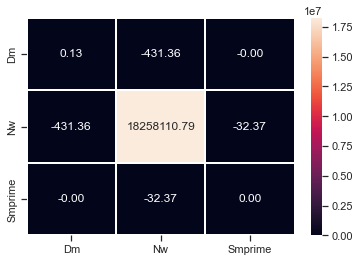

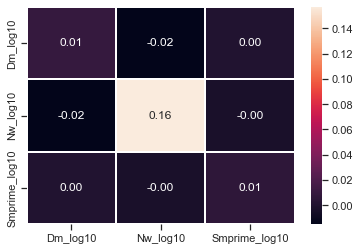

In [7]:
S_a = rainDat_training.to_dataframe().cov()
x_ap = rainDat_training.to_dataframe().mean()
print(x_ap)

plt.figure()
sns.heatmap(
    S_a[
        ['Dm', 'Nw', 'Smprime']
    ].loc[
        ['Dm', 'Nw', 'Smprime']
    ],
    annot=True,
    fmt='.2f',
    linewidths=.05)

plt.figure()
sns.heatmap(
    S_a[
        ['Dm_log10', 'Nw_log10', 'Smprime_log10']
    ].loc[
        ['Dm_log10', 'Nw_log10', 'Smprime_log10']
    ],
    annot=True,
    fmt='.2f',
    linewidths=.05)

When estimating the prior, the use of SI units is not always recommended: Combining small and large quantities with different units (e.g. temperature in K and specific humidity in kg/kg), the prior can be singular prohibiting an efficient use. 

## Measurement space

The measurement vector $\mathbf{y}$ consists of the radar reflectivity factor ($Z$) and the mean Doppler velocity ($V_d$) at 13.6 GHz and 35.5 GHz. Even though we use only 13.6 GHz in the following, we encourage the reader to experiment with different $\mathbf{y}$ combinations. For  **S**$_y$, we assume that the uncertainties of  $Z$ and $V_d$ are 1 dB and 0.3 m s$^{-1}$, respectively, and that the errors are not correlated. Even though these error estimates are generally realistic, the values should be carefully evaluated for a real world application.

<AxesSubplot:>

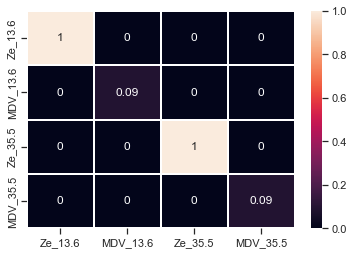

In [8]:
y_vars = ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]
y_noise = np.array([1, .3, 1, .3])
S_y = pn.DataFrame(
    np.diag(y_noise**2),
    index=y_vars,
    columns=y_vars,
)
sns.heatmap(S_y, annot=True, fmt='g', linewidths=.05)

## Forward operator
To prepare the retrieval, we set up PAMTRA2 properly and create dictionaries to store the results.

In [9]:
pam2Prepared = supporting_routines.preparePamtra(frequencies=[13.6e9, 35.5e9])


Did not find information about relativePermittivityIce. This might cause trouble later.


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/pamtra2-0.1-py3.8-macosx-10.9-x86_64.egg/pamtra2/hydrometeors/scattering.py:80: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  scatteringProperty = xr.apply_ufunc(
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/pamtra2-0.1-py3.8-macosx-10.9-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos_th*cos_inc)/(sin_th*sin_inc))
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/pamtra2-0.1-py3.8-macosx-10.9-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:171: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.arccos((cos_inc-cos_th*cos_sca)/(sin_th*sin_sca))


The message about `relativePermittivityIce` can be ignored. After this, the forward operator can be run with `supporting_routines.forwardPamtra`.  In short, the forward operator accepts $\mathbf{x}$ as an input argument and returns $\mathbf{y}$. In addition, `pam2Prepared` (prepared above) and the list of $\mathbf{y}$ elements to be returned needs to be provided. See `libs/supporting_routines.py` for details.

# Example retrieval

First, we need names for the elements of $\mathbf{x}$  and $\mathbf{y}$ 

In [10]:
x_vars = ['Dm', 'Nw', 'Smprime']
y_vars = ["Ze_13.6", "MDV_13.6"]

Additional  variables required for the forward operator

In [11]:
forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

We use the 51st profile from the test data set as $\mathbf{x}_{truth}$

In [12]:
tt = 51
x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]

For simplicity, we use synthetic observations, i.e. we use PAMTRA2 to simulate an observation based on a known atmospheric state $\mathbf{x}_{truth}$. Even though $\mathbf{x}_{truth}$ is typically unknown in a real-world example, the use of synthetic observations is extremely helpful for assessing retrieval performance by comparing $\mathbf{x}_{op}$ to $\mathbf{x}_{truth}$. The `**forwardKwArgs` passes all dictionary values of `forwardKwArgs` as named function arguments (see https://www.geeksforgeeks.org/args-kwargs-python/).

In [13]:
y_obs = supporting_routines.forwardPamtra(
    x_truth,
    **forwardKwArgs,
)
y_obs

Ze_13.6     29.756770
MDV_13.6     6.194538
dtype: float64

`pyOptimalEstimation` uses objects. Therefore, we combine all information for the reference run into an object which we name `oe` 

In [14]:
# create optimal estimation object
oe = pyOE.optimalEstimation(
    x_vars,  # state variable names
    x_ap[x_vars],  # a priori
    S_a[x_vars].loc[x_vars],  # a priori uncertainty
    y_vars,  # measurement variable names
    y_obs,  # observations
    S_y[y_vars].loc[y_vars],  # observation uncertainty
    supporting_routines.forwardPamtra,  # forward Operator
    forwardKwArgs=forwardKwArgs,  # additonal function arguments
)

We store the true profile in the `oe` object. This is just for convenience, it is not
used by the retrieval.

In [15]:
oe.x_truth = x_truth

We run the retrieval with max. 10 iterations.

In [16]:
converged = oe.doRetrieval(maxIter=10)

0.30 s, iteration 1, degrees of freedom: 1.92 of 3, not converged (x-space):  1.375
0.42 s, iteration 2, degrees of freedom: 1.91 of 3, converged (x-space):  0.001
0.56 s, iteration 3, degrees of freedom: 1.91 of 3, done.  0.000


It converges after 2 iterations. 1.91 degrees of freedom for signal $d$ (the number of independent information pieces) are retrieved which is shows the good performance of the retrieval given that the maximum $d$ value is 2 because $\mathbf{y}$ consists of 2 measurements. 

After convergence, the solution $\mathbf{x}_{op}$ and the retrieved uncertainty **S**$_{op}$ is available with

In [17]:
print(oe.x_op)
print(oe.S_op)

Dm            1.444864
Nw         2102.003124
Smprime       0.306848
dtype: float64
                 Dm            Nw    Smprime
Dm         0.016757 -1.698757e+02  -0.004985
Nw      -169.875723  2.066878e+06  42.193265
Smprime   -0.004985  4.219327e+01   0.002522


pyOptimalEstimation uses Pandas objects not only for the input, but also for the output to make sure the elements of $\mathbf{x}$ and $\mathbf{y}$ are not mixed up.

For convenience, the 1 $\sigma$ uncertainties derived from **S**$_{op}$ are also available

In [18]:
print(oe.x_op_err)

Dm            0.129451
Nw         1437.664246
Smprime       0.050219
dtype: float64


$d$ is available as a total as well as per $\mathbf{x}$ variable

In [19]:
print('total', oe.dgf)
print(oe.dgf_x)

total 1.9093322923665506
Dm         0.904881
Nw         0.881159
Smprime    0.123292
dtype: float64


We recommend to apply various statistical tests to the result with the `chiSquareTest()` function. The tests include:

1. $\mathbf{y}_{op}$  agrees with the measurement $\mathbf{y}_{obs}$ (`Y_Optimal_vs_Observation`, Rodgers, 2000, Sec. 12.3.2) 
2. the observation $\mathbf{y}_{obs}$ agrees with the prior **S**$_a$ (`Y_Observation_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.1) 
3. the retrieved measurement agrees with the prior **S**$_a$ (`Y_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.3) 
4. the retrieved state $\mathbf{x}_{op}$ agrees with the prior **S**$_a$ (`X_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.2) 



In [20]:
print(oe.chiSquareTest()[0])

Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


Finally, we test with `testLinearity()`  whether the forward operator is moderately linear following chapter 5.1 of Rodgers 2000. The analysis for this example is based on $\mathbf{x}_{truth}$. The $\chi^2$ value (`trueLinearityChi2`) corresponding to the model beeing moderately linear must be smaller than the critical value (`trueLinearityChi2Crit`).

The first returned element is a boolean indicating whether the $\chi^2$ tests were successful: 

In [21]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(
    significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Linearity test passed:  False


The fact that this test fails indicates already that the retrieval with linear $\mathbf{x}$ variables does not work properly (see below).

When running several retrievals, we recommend using the `oe.summarize` function which summarizes all retrieval results in an Xarray Dataset (which is structured similar to a netCDF file):

In [22]:
oe.summarize(returnXarray=True)

<xarray.Dataset>
Dimensions:                    (chi2test: 4, x_vars: 3, x_vars_T: 3, y_vars: 2, y_vars_T: 2)
Coordinates:
  * x_vars                     (x_vars) object 'Dm' 'Nw' 'Smprime'
  * x_vars_T                   (x_vars_T) object 'Dm' 'Nw' 'Smprime'
  * y_vars                     (y_vars) object 'Ze_13.6' 'MDV_13.6'
  * y_vars_T                   (y_vars_T) object 'Ze_13.6' 'MDV_13.6'
  * chi2test                   (chi2test) object 'Y_Optimal_vs_Observation' ....
Data variables: (12/17)
    x_a                        (x_vars) float64 1.462 4.055e+03 0.2996
    x_a_err                    (x_vars) float64 0.3585 4.273e+03 0.05471
    S_a                        (x_vars, x_vars_T) float64 0.1285 ... 0.002993
    x_op                       (x_vars) float64 1.445 2.102e+03 0.3068
    x_op_err                   (x_vars) float64 0.1295 1.438e+03 0.05022
    S_op                       (x_vars, x_vars_T) float64 0.01676 ... 0.002522
    ...                         ...
    trueLinearityChi2          float64 10.53
    trueLinearityChi2Critical  float64 5.991
    chi2value                  (chi2test) float64 0.2741 0.1652 0.1614 0.2572
    chi2critical               (chi2test) float64 5.991 5.991 5.991 5.991
    dgf                        float64 1.909
    convergedIteration         int64 3

# Run retrieval

After we presented the retrieval step-by-step, we integrate everything into a loop to apply the retrieval to all 100 profiles. 

The results are saved in dictionaries:

In [23]:
resultsOE = {}
failed = {}

To compare performance, we run the retrieval in two configurations:

1. linear state variables (see the step-by-step example above)
2. logarithmic state variables


In [24]:
#     name, [X_variables],
x_names = dict([
    ('Linear', ['Dm', 'Nw', 'Smprime']),
    ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
])

In this study, we use only a measurement configuration consisting of a radar reflectivity ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$). But the example is designed to work also with dual-frequency set ups and we encourage the reader to experiment  with different configurations. 


In [25]:
#     name, [Y_variables],
y_names = dict([
    ('Z', ["Ze_13.6"]),
    ('ZW', ["Ze_13.6", "MDV_13.6"]),
    ('Zdual', ["Ze_13.6", "Ze_35.5"]),
    ('ZWdual', ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]),
])

In [26]:
%%time
for x_name, y_name in (
    (
        'Linear',
        'ZW',
    ),
    ('log$_{10}$', 'ZW'),
):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    resultsOE['%s %s' % (x_name, y_name)] = []
    failed['%s %s' % (x_name, y_name)] = []

    #Additional required variables for the forward operator
    forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

    print('#' * 80)
    print(x_name, y_name)
    print('#' * 80)
 
    #     for tt in [15, 20, 51]:
    for tt in range(rainDat_test[x_vars].time.shape[0]):

        x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]
        # simulate observation based on true state x_truth
        y_obs = supporting_routines.forwardPamtra(
            x_truth,
            pam2=pam2Prepared,
            y_vars=y_vars,
        )

        # create optimal estimation object
        oe = pyOE.optimalEstimation(
            x_vars,  # state variable names
            x_ap[x_vars],  # a priori
            S_a[x_vars].loc[x_vars],  # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs,  # observations
            S_y[y_vars].loc[y_vars],  # observation uncertainty
            supporting_routines.forwardPamtra,  # forward Operator
            forwardKwArgs=forwardKwArgs,  # additonal function arguments
        )

        # Store true profile in `oe` object. This is just for convenience, it is not
        # used by the retrieval.
        oe.x_truth = x_truth

        # Do the retrieval with max. 10 iterations.
        converged = oe.doRetrieval(maxIter=10)

        if converged:

            # Test whethe rthe retrieval is moderately lienar around x_truth
            print(oe.linearityTest())

            # Show hdegrees of freedom per variable
            print(oe.dgf_x)

            # Apply chi2 tests for retrieval quality
            print(oe.chiSquareTest())

            if x_name.startswith('log'):
                # Show RMS normalized with prior
                print(
                    'RMS log',
                    np.sqrt(
                        np.mean(
                            ((10**oe.x_truth - 10**oe.x_op) / 10**oe.x_a)**2)))
                print('truth', 10**oe.x_truth)
                print('op', 10**unp.uarray(oe.x_op.values, oe.x_op_err.values))
            else:
                # Show RMS normalized with prior
                print('RMS',
                      np.sqrt(np.mean(((oe.x_truth - oe.x_op) / oe.x_a)**2)))
                print('truth', oe.x_truth)
                print('op', unp.uarray(oe.x_op.values, oe.x_op_err.values))

            #Store results in xarray DataArray
            summary = oe.summarize(returnXarray=True)
            summary['time'] = rainDat_test[x_vars].time[tt]

            resultsOE['%s %s' % (x_name, y_name)].append(summary)
        else:
            failed['%s %s' % (x_name, y_name)].append(tt)

    #Store results in xarray Dataset structure for later analysis.
    resultsOE['%s %s' % (x_name, y_name)] = xr.concat(
        resultsOE['%s %s' % (x_name, y_name)], dim='time')

################################################################################
Linear ZW
################################################################################
0.28 s, iteration 1, degrees of freedom: 1.77 of 3, converged (x-space):  0.017
0.40 s, iteration 2, degrees of freedom: 1.77 of 3, done.  0.000
([1.3166449966161067, 0.0006750759851563324, 0.0005244346764852817], array(0.06722079), 5.991464547107983)
Dm         0.967234
Nw         0.610596
Smprime    0.196107
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.170134
Y_Observation_vs_Prior      0.163760
Y_Optimal_vs_Prior          0.166656
X_Optimal_vs_Prior          0.161910
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_

0.32 s, iteration 1, degrees of freedom: 1.94 of 3, not converged (x-space):  3.753
0.47 s, iteration 2, degrees of freedom: 1.92 of 3, converged (x-space):  0.001
0.61 s, iteration 3, degrees of freedom: 1.92 of 3, done.  0.000
([6.796875046062216, 0.0013430031961421504, 0.00017781163913994902], array(0.04821977), 5.991464547107983)
Dm         0.902085
Nw         0.908848
Smprime    0.111050
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.439910
Y_Observation_vs_Prior      0.208485
Y_Optimal_vs_Prior          0.204488
X_Optimal_vs_Prior          0.364131
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.9

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.33 s, iteration 1, degrees of freedom: 0.96 of 3, not converged (x-space):  15.879
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.48 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.32 s, iteration 1, degrees of freedom: 1.59 of 3, not converged (x-space):  1.320
0.46 s, iteration 2, degrees of freedom: 1.60 of 3, converged (x-space):  0.000
0.60 s, iteration 3, degrees of freedom: 1.60 of 3, done.  0.000
([0.3226573772153039, 0.000962727015423207, 0.00035066434624969893], array(0.69132494), 5.991464547107983)
Dm         0.994623
Nw         0.360572
Smprime    0.241496
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.170788
Y_Observation_vs_Prior      3.181293
Y_Optimal_vs_Prior          3.979957
X_Optimal_vs_Prior          2.169219
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.9

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.31 s, iteration 1, degrees of freedom: 0.92 of 3, not converged (x-space):  12.487
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.44 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.30 s, iteration 1, degrees of freedom: 1.87 of 3, not converged (x-space):  0.424
0.43 s, iteration 2, degrees of freedom: 1.87 of 3, converged (x-space):  0.000
0.55 s, iteration 3, degrees of freedom: 1.87 of 3, done.  0.000
([3.1664735804918633, 0.000609973286648389, 0.00047036018805062527], array(0.060915), 5.991464547107983)
Dm         0.950347
Nw         0.795635
Smprime    0.121554
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.566047
Y_Observation_vs_Prior      0.512309
Y_Optimal_vs_Prior          0.511383
X_Optimal_vs_Prior          0.567957
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.29 s, iteration 1, degrees of freedom: 0.88 of 3, not converged (x-space):  14.529
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.43 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.30 s, iteration 1, degrees of freedom: 1.77 of 3, not converged (x-space):  17.701
0.44 s, iteration 2, degrees of freedom: 1.66 of 3, converged (x-space):  0.105
0.58 s, iteration 3, degrees of freedom: 1.66 of 3, done.  0.013
([6.944412365851526, 0.0018699326469823695, 0.0009209619873985525], array(126.72529633), 5.991464547107983)
Dm         0.667567
Nw         0.815457
Smprime    0.173813
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation    11.942874
Y_Observation_vs_Prior      25.862501
Y_Optimal_vs_Prior          32.490375
X_Optimal_vs_Prior          10.064775
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior   

0.26 s, iteration 1, degrees of freedom: 1.85 of 3, converged (x-space):  0.299
0.38 s, iteration 2, degrees of freedom: 1.84 of 3, done.  0.000
([4.572981829909898, 0.002198703694656278, 9.782478789359346e-05], array(0.00638305), 5.991464547107983)
Dm         0.876654
Nw         0.782167
Smprime    0.179094
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.499743
Y_Observation_vs_Prior      0.783396
Y_Optimal_vs_Prior          0.805974
X_Optimal_vs_Prior          0.602720
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.05852810677172043
truth Dm            

0.25 s, iteration 1, degrees of freedom: 1.91 of 3, not converged (x-space):  0.619
0.37 s, iteration 2, degrees of freedom: 1.90 of 3, converged (x-space):  0.000
0.48 s, iteration 3, degrees of freedom: 1.90 of 3, done.  0.000
([4.533489984030321, 0.0011213299228383738, 0.0002676931017996174], array(4.47128077e-05), 5.991464547107983)
Dm         0.921393
Nw         0.854051
Smprime    0.123855
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.279857
Y_Observation_vs_Prior      0.212041
Y_Optimal_vs_Prior          0.209712
X_Optimal_vs_Prior          0.275081
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: Runt

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.25 s, iteration 1, degrees of freedom: 0.95 of 3, not converged (x-space):  1.963
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.36 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000
0.27 s, iteration 1, degrees of freedom: 1.59 of 3, not converged (x-space):  1.285
0.38 s, iteration 2, de

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: Runt

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.25 s, iteration 1, degrees of freedom: 0.95 of 3, not converged (x-space):  4.006
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.36 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000
0.24 s, iteration 1, degrees of freedom: 1.56 of 3, not converged (x-space):  2.052
0.36 s, iteration 2, de

0.25 s, iteration 1, degrees of freedom: 1.80 of 3, not converged (x-space):  1.543
0.37 s, iteration 2, degrees of freedom: 1.78 of 3, converged (x-space):  0.000
0.48 s, iteration 3, degrees of freedom: 1.78 of 3, done.  0.000
([2.04884420111343, 0.0016813140207073488, 0.0003046983517743355], array(0.00026284), 5.991464547107983)
Dm         0.980263
Nw         0.674530
Smprime    0.121112
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.454145
Y_Observation_vs_Prior      1.249811
Y_Optimal_vs_Prior          1.274985
X_Optimal_vs_Prior          1.417232
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.48 s, iteration 1, degrees of freedom: 0.94 of 3, not converged (x-space):  5.277
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.67 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.38 s, iteration 1, degrees of freedom: 1.91 of 3, not converged (x-space):  5.650
0.56 s, iteration 2, degrees of freedom: 1.89 of 3, converged (x-space):  0.003
0.76 s, iteration 3, degrees of freedom: 1.89 of 3, done.  0.000
([9.85084186988552, 0.00222678901602935, 0.00012553350023268114], array(0.01496532), 5.991464547107983)
Dm         0.834100
Nw         0.905443
Smprime    0.147986
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.830785
Y_Observation_vs_Prior      1.025026
Y_Optimal_vs_Prior          1.038464
X_Optimal_vs_Prior          0.837572
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.9914

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.39 s, iteration 1, degrees of freedom: 0.91 of 3, not converged (x-space):  9.952
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.56 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.39 s, iteration 1, degrees of freedom: 1.76 of 3, not converged (x-space):  1.737
0.57 s, iteration 2, degrees of freedom: 1.75 of 3, converged (x-space):  0.003
0.76 s, iteration 3, degrees of freedom: 1.74 of 3, done.  0.000
([3.8843350707926922, 0.0017781218557492286, 0.0004597588285147772], array(0.00821052), 5.991464547107983)
Dm         0.841484
Nw         0.692967
Smprime    0.209261
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.511240
Y_Observation_vs_Prior      4.348133
Y_Optimal_vs_Prior          4.705910
X_Optimal_vs_Prior          2.533836
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.9

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.32 s, iteration 1, degrees of freedom: 0.96 of 3, not converged (x-space):  2.346
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.46 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.32 s, iteration 1, degrees of freedom: 1.93 of 3, not converged (x-space):  4.831
0.48 s, iteration 2, degrees of freedom: 1.92 of 3, converged (x-space):  0.002
0.63 s, iteration 3, degrees of freedom: 1.92 of 3, done.  0.000
([7.895312702389528, 0.0018933011540858756, 4.05878776085516e-05], array(0.10224915), 5.991464547107983)
Dm         0.879562
Nw         0.912120
Smprime    0.124626
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.405612
Y_Observation_vs_Prior      0.198723
Y_Optimal_vs_Prior          0.192959
X_Optimal_vs_Prior          0.327408
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.31 s, iteration 1, degrees of freedom: 0.88 of 3, not converged (x-space):  17.398
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.46 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.29 s, iteration 1, degrees of freedom: 1.71 of 3, converged (x-space):  0.296
0.43 s, iteration 2, degrees of freedom: 1.71 of 3, done.  0.001
([1.3268335212636382, 0.0020064942374671407, 7.406318317528096e-05], array(0.00017427), 5.991464547107983)
Dm         0.930158
Nw         0.530164
Smprime    0.254653
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.136657
Y_Observation_vs_Prior      1.144488
Y_Optimal_vs_Prior          1.129159
X_Optimal_vs_Prior          0.957657
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.051598959172778375
truth Dm         

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.30 s, iteration 1, degrees of freedom: 0.89 of 3, not converged (x-space):  17.940
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.46 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: Runt

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.33 s, iteration 1, degrees of freedom: 0.82 of 3, not converged (x-space):  20.952
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.49 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.32 s, iteration 1, degrees of freedom: 1.86 of 3, converged (x-space):  0.262
0.46 s, iteration 2, degrees of freedom: 1.86 of 3, done.  0.000
([2.8890138814175077, 0.0005926254389186393, 0.000513807411682332], array(0.46761068), 5.991464547107983)
Dm         0.951460
Nw         0.777569
Smprime    0.130092
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.542845
Y_Observation_vs_Prior      0.431933
Y_Optimal_vs_Prior          0.430579
X_Optimal_vs_Prior          0.469374
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.33286752924548746
truth Dm           

0.34 s, iteration 1, degrees of freedom: 1.91 of 3, not converged (x-space):  1.493
0.47 s, iteration 2, degrees of freedom: 1.89 of 3, converged (x-space):  0.001
0.61 s, iteration 3, degrees of freedom: 1.89 of 3, done.  0.000
([6.673431761012383, 0.0021358416702376526, 3.797857297040418e-05], array(0.22375304), 5.991464547107983)
Dm         0.873064
Nw         0.874165
Smprime    0.144974
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.367494
Y_Observation_vs_Prior      0.355320
Y_Optimal_vs_Prior          0.352513
X_Optimal_vs_Prior          0.366175
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.99

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.31 s, iteration 1, degrees of freedom: 0.94 of 3, not converged (x-space):  3.001
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.46 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.32 s, iteration 1, degrees of freedom: 1.95 of 3, not converged (x-space):  49.904
0.46 s, iteration 2, degrees of freedom: 1.94 of 3, not converged (x-space):  0.765
0.61 s, iteration 3, degrees of freedom: 1.93 of 3, converged (x-space):  0.003
0.75 s, iteration 4, degrees of freedom: 1.93 of 3, done.  0.000
([11.89881774227151, 0.0018447019099098862, 4.699817050742438e-05], array(2.67587646), 5.991464547107983)
Dm         0.869466
Nw         0.950281
Smprime    0.111915
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.476081
Y_Observation_vs_Prior      0.192625
Y_Optimal_vs_Prior          0.187855
X_Optimal_vs_Prior          0.450550
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prio

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.33 s, iteration 1, degrees of freedom: 0.96 of 3, not converged (x-space):  2.886
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.48 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.36 s, iteration 1, degrees of freedom: 1.80 of 3, converged (x-space):  0.195
0.50 s, iteration 2, degrees of freedom: 1.80 of 3, done.  0.000
([1.7877807646113257, 0.0010204157887496455, 0.0006531290931715999], array(6.78851106e-05), 5.991464547107983)
Dm         0.970367
Nw         0.674172
Smprime    0.151882
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.659128
Y_Observation_vs_Prior      0.524539
Y_Optimal_vs_Prior          0.525689
X_Optimal_vs_Prior          0.560242
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.02697490483602071
truth Dm      

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.34 s, iteration 1, degrees of freedom: 0.96 of 3, not converged (x-space):  25.315
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 2
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 2
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 2
0.49 s, iteration 2, degrees of freedom: 0.00 of 3.degrees of freedom 0! STOP  0.000


/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


0.37 s, iteration 1, degrees of freedom: 1.89 of 3, not converged (x-space):  3.951
0.52 s, iteration 2, degrees of freedom: 1.87 of 3, converged (x-space):  0.001
0.67 s, iteration 3, degrees of freedom: 1.87 of 3, done.  0.000
([9.402456663788524, 0.002151728776496398, 0.00021149090418072633], array(0.00157901), 5.991464547107983)
Dm         0.820983
Nw         0.886952
Smprime    0.158480
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.197734
Y_Observation_vs_Prior      1.740111
Y_Optimal_vs_Prior          1.792464
X_Optimal_vs_Prior          1.219584
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.99

0.44 s, iteration 1, degrees of freedom: 1.95 of 3, not converged (x-space):  11.456
0.61 s, iteration 2, degrees of freedom: 1.93 of 3, converged (x-space):  0.006
0.79 s, iteration 3, degrees of freedom: 1.93 of 3, done.  0.000
([7.6552007942856966, 0.0006013201314181687, 0.00048133608390395915], array(1.36906831), 5.991464547107983)
Dm         0.924811
Nw         0.928947
Smprime    0.078055
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.386293
Y_Observation_vs_Prior      0.680879
Y_Optimal_vs_Prior          0.678478
X_Optimal_vs_Prior          0.996777
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5

0.34 s, iteration 1, degrees of freedom: 1.78 of 3, converged (x-space):  0.004
0.49 s, iteration 2, degrees of freedom: 1.78 of 3, done.  0.000
([0.009574651361316432, 0.0005461499341752263, 0.00017481988848661308], array(0.00371342), 5.991464547107983)
Dm_log10         0.949465
Nw_log10         0.649481
Smprime_log10    0.183071
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.677390
Y_Observation_vs_Prior      0.680062
Y_Optimal_vs_Prior          0.679679
X_Optimal_vs_Prior          0.675127
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.11886319875

0.33 s, iteration 1, degrees of freedom: 1.79 of 3, converged (x-space):  0.013
0.48 s, iteration 2, degrees of freedom: 1.79 of 3, done.  0.000
([0.009556424008159427, 0.0006079874975427209, 0.0001951806573316543], array(1.12970045e-05), 5.991464547107983)
Dm_log10         0.945339
Nw_log10         0.640706
Smprime_log10    0.200583
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    4.589331
Y_Observation_vs_Prior      4.581415
Y_Optimal_vs_Prior          4.573503
X_Optimal_vs_Prior          4.582312
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.06395197

0.38 s, iteration 1, degrees of freedom: 1.73 of 3, not converged (x-space):  0.338
0.53 s, iteration 2, degrees of freedom: 1.73 of 3, converged (x-space):  0.000
0.69 s, iteration 3, degrees of freedom: 1.73 of 3, done.  0.000
([0.010931968953538134, 0.0001314583665576811, 0.00010739743830039697], array(0.0041628), 5.991464547107983)
Dm_log10         0.953885
Nw_log10         0.660938
Smprime_log10    0.113517
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.518802
Y_Observation_vs_Prior      3.069855
Y_Optimal_vs_Prior          3.246443
X_Optimal_vs_Prior          2.518563
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_v

0.34 s, iteration 1, degrees of freedom: 1.73 of 3, not converged (x-space):  0.459
0.49 s, iteration 2, degrees of freedom: 1.72 of 3, converged (x-space):  0.000
0.64 s, iteration 3, degrees of freedom: 1.72 of 3, done.  0.000
([0.010288049132235575, 0.00012110928260771793, 8.743192184658466e-05], array(0.06509915), 5.991464547107983)
Dm_log10         0.953044
Nw_log10         0.657635
Smprime_log10    0.109752
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.401801
Y_Observation_vs_Prior      3.087211
Y_Optimal_vs_Prior          3.308573
X_Optimal_vs_Prior          2.400758
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_

0.47 s, iteration 1, degrees of freedom: 1.79 of 3, converged (x-space):  0.005
0.70 s, iteration 2, degrees of freedom: 1.79 of 3, done.  0.000
([0.0047544003607516904, 0.00126846623105538, 4.480349108548569e-05], array(0.00968042), 5.991464547107983)
Dm_log10         0.943758
Nw_log10         0.623405
Smprime_log10    0.225798
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.553050
Y_Observation_vs_Prior      1.522087
Y_Optimal_vs_Prior          1.513134
X_Optimal_vs_Prior          1.547162
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.1567638704105

0.33 s, iteration 1, degrees of freedom: 1.79 of 3, converged (x-space):  0.024
0.47 s, iteration 2, degrees of freedom: 1.79 of 3, done.  0.000
([0.003812192598376362, 0.0014602350795898573, 3.785068000147252e-05], array(0.09826533), 5.991464547107983)
Dm_log10         0.940408
Nw_log10         0.612468
Smprime_log10    0.241684
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    3.254267
Y_Observation_vs_Prior      3.165862
Y_Optimal_vs_Prior          3.139883
X_Optimal_vs_Prior          3.229077
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.216993177627

0.60 s, iteration 1, degrees of freedom: 1.73 of 3, not converged (x-space):  0.366
0.96 s, iteration 2, degrees of freedom: 1.73 of 3, converged (x-space):  0.000
1.24 s, iteration 3, degrees of freedom: 1.73 of 3, done.  0.000
([0.010675830544429433, 0.0001459697578335706, 9.501895500308519e-05], array(0.00031052), 5.991464547107983)
Dm_log10         0.951174
Nw_log10         0.651934
Smprime_log10    0.123204
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.624837
Y_Observation_vs_Prior      1.981694
Y_Optimal_vs_Prior          2.055774
X_Optimal_vs_Prior          1.624815
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_v

0.32 s, iteration 1, degrees of freedom: 1.78 of 3, converged (x-space):  0.032
0.46 s, iteration 2, degrees of freedom: 1.78 of 3, done.  0.000
([0.002904632927601655, 0.0012594873093270161, 6.137070917096944e-05], array(0.22155861), 5.991464547107983)
Dm_log10         0.941779
Nw_log10         0.601064
Smprime_log10    0.234018
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.392882
Y_Observation_vs_Prior      1.456628
Y_Optimal_vs_Prior          1.476992
X_Optimal_vs_Prior          1.367570
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.277088602342

0.32 s, iteration 1, degrees of freedom: 1.78 of 3, converged (x-space):  0.003
0.50 s, iteration 2, degrees of freedom: 1.78 of 3, done.  0.000
([0.0045211212849181285, 0.0011555109323616599, 3.923669923700946e-05], array(0.01141336), 5.991464547107983)
Dm_log10         0.946329
Nw_log10         0.623625
Smprime_log10    0.214423
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.320136
Y_Observation_vs_Prior      0.324100
Y_Optimal_vs_Prior          0.325845
X_Optimal_vs_Prior          0.318109
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.20070957670

0.33 s, iteration 1, degrees of freedom: 1.73 of 3, converged (x-space):  0.213
0.47 s, iteration 2, degrees of freedom: 1.73 of 3, done.  0.001
([0.00066832504939936, 0.0005109840477931334, 0.00021624676391992457], array(0.05417068), 5.991464547107983)
Dm_log10         0.929159
Nw_log10         0.543103
Smprime_log10    0.257033
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation     True
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool, chi2test
Y_Optimal_vs_Observation    5.802450
Y_Observation_vs_Prior      7.565028
Y_Optimal_vs_Prior          8.191408
X_Optimal_vs_Prior          5.774723
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.27671577

0.30 s, iteration 1, degrees of freedom: 1.78 of 3, converged (x-space):  0.001
0.43 s, iteration 2, degrees of freedom: 1.78 of 3, done.  0.000
([0.004872104214886245, 0.000997320086963968, 4.015516356134417e-05], array(0.00785286), 5.991464547107983)
Dm_log10         0.949279
Nw_log10         0.629022
Smprime_log10    0.200399
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.269002
Y_Observation_vs_Prior      0.259231
Y_Optimal_vs_Prior          0.258053
X_Optimal_vs_Prior          0.268644
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.3941150625775

0.33 s, iteration 1, degrees of freedom: 1.78 of 3, converged (x-space):  0.013
0.46 s, iteration 2, degrees of freedom: 1.78 of 3, done.  0.000
([0.0036663323200157296, 0.0012717972035716646, 4.2232878471241955e-05], array(0.06013996), 5.991464547107983)
Dm_log10         0.943697
Nw_log10         0.612817
Smprime_log10    0.226665
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.930352
Y_Observation_vs_Prior      0.944133
Y_Optimal_vs_Prior          0.948857
X_Optimal_vs_Prior          0.919856
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.2256521187

0.29 s, iteration 1, degrees of freedom: 1.73 of 3, not converged (x-space):  0.366
0.43 s, iteration 2, degrees of freedom: 1.73 of 3, converged (x-space):  0.000
0.56 s, iteration 3, degrees of freedom: 1.73 of 3, done.  0.000
([0.01067418822841933, 0.00014514406532086646, 9.503841714905508e-05], array(3.23885297e-05), 5.991464547107983)
Dm_log10         0.951259
Nw_log10         0.652208
Smprime_log10    0.122753
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.598182
Y_Observation_vs_Prior      1.964351
Y_Optimal_vs_Prior          2.042817
X_Optimal_vs_Prior          1.598130
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optim

0.30 s, iteration 1, degrees of freedom: 1.72 of 3, not converged (x-space):  0.576
0.43 s, iteration 2, degrees of freedom: 1.71 of 3, converged (x-space):  0.000
0.56 s, iteration 3, degrees of freedom: 1.71 of 3, done.  0.000
([0.00970050582465707, 0.000132529557245747, 7.019274954307379e-05], array(0.0133705), 5.991464547107983)
Dm_log10         0.949704
Nw_log10         0.645376
Smprime_log10    0.119893
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.805753
Y_Observation_vs_Prior      3.196650
Y_Optimal_vs_Prior          3.258050
X_Optimal_vs_Prior          2.805858
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_P

# Analyze results


## Compare retrieval quality

Here we compare the retrieval quality by comparing the number of profiles that converged, passed the $\chi^2$-tests, and the linearity test:

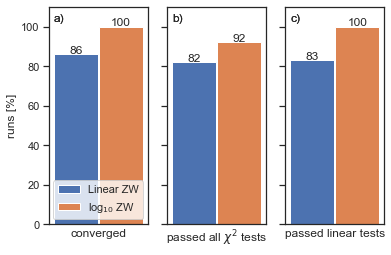

In [27]:
fig, sps = plt.subplots(ncols=3, sharey=True, figsize=(6, 4))

for kk, key in enumerate(resultsOE.keys()):

    converged = len(resultsOE[key].time)
    passedLinearity = (resultsOE[key].trueLinearityChi2 <
                       resultsOE[key].trueLinearityChi2Critical).sum().values
    passedChi2 = (resultsOE[key].chi2value <
                  resultsOE[key].chi2critical).all('chi2test').sum().values

    sps[0].bar(kk, converged, label=key, width=0.98)
    sps[1].bar(kk, passedChi2, label=key, width=0.98)
    sps[2].bar(kk, passedLinearity, label=key, width=0.98)

    sps[0].text(
        kk, converged + .25, str(converged), horizontalalignment='center')
    sps[1].text(
        kk, passedChi2 + .25, str(passedChi2), horizontalalignment='center')
    sps[2].text(
        kk,
        passedLinearity + .25,
        str(passedLinearity),
        horizontalalignment='center')

    sps[0].set_xticks([])
    sps[1].set_xticks([])
    sps[2].set_xticks([])
    sps[0].set_xlabel('converged')
    sps[2].set_xlabel('passed linear tests')
    sps[1].set_xlabel('passed all $\chi^2$ tests')

    sps[0].set_ylabel('runs [%]')
    sps[0].set_ylim(0, 110)
    sps[0].legend(loc='lower center')

    for ii in range(3):
        sps[ii].text(
            0.05,
            0.97,
            '%s)' % (abc[ii]),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[ii].transAxes)

Independently how performance is measured, the version with the logarithmic $\mathbf{x}$ variables performs better. It should be noted that applying a $\chi^2$ test with 5% confidence interval to a larger number of retrievals means that 5% of the profiles do not pass the test even though they are fine.

## Compare retrieval error distributions

Similar to the prior, we also compare the distributions of relative retrieval errors defined with

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathsf{S}_y)}}
   \end{equation}

In theory, the relative retrieval errors should follow a normal distribution with mean 0 and standard deviation 1. 

Linear ZW Dm 0.0721660401842901 0.7005116962771077
Linear ZW Nw -0.2311334878438901 0.6793344847711106
Linear ZW Smprime 0.0125998301553978 0.847075736035381
log$_{10}$ ZW Dm_log10 0.059557288358796055 0.8885320534440038
log$_{10}$ ZW Nw_log10 -0.04929724584020318 0.824728089964991
log$_{10}$ ZW Smprime_log10 0.06874301716219064 0.9947203205079413


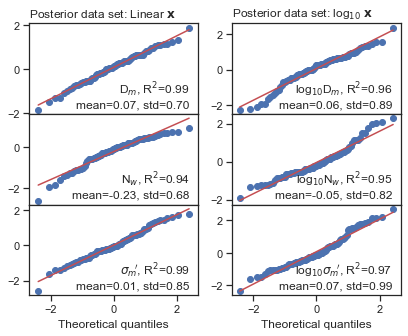

In [28]:
ncols = len(resultsOE.keys())
fig, sps = plt.subplots(
    figsize=(3.33 * ncols, 5), nrows=len(x_vars), ncols=ncols, sharex=True)

sps = sps.reshape((len(x_vars), ncols))

jj = 0

for yy, key in enumerate(resultsOE.keys()):

    for kk in range(3):

        x_var = resultsOE[key].x_vars.values[kk]
        thisOe = resultsOE[key].isel(x_vars=kk)
        passedChiTests = (thisOe.chi2value <=
                          thisOe.chi2critical).all('chi2test')
        thisOe = thisOe.where(passedChiTests).dropna('time')
        x_err = ((thisOe['x_op'] - thisOe['x_truth']) / thisOe['x_op_err'])

        x_mean = x_err.mean().values
        x_std = x_err.std().values

        print(key, x_var, x_mean, x_std)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            x_err, dist="norm", plot=sps[kk, yy], fit=True, rvalue=False)

        sps[kk, yy].set_title('')
        if kk == 0:
            sps[kk, yy].set_title(
                'Posterior data set: %s $\mathbf{x}$' %
                (key.split(' ')[0]),
                loc='left')

        sps[kk, yy].text(
            0.95,
            0.05,
            '%s, R$^2$=%.2f\nmean=%.2f, std=%.2f' %
            (supporting_routines.niceKeys[x_var], r**2, x_mean, x_std),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=sps[kk, yy].transAxes)

        if kk < 2:
            sps[kk, yy].set_xlabel("")
        sps[kk, yy].set_ylabel("")

        jj += 1

fig.subplots_adjust(hspace=0)

With one exception, mean and standard deviation are closer to 0 and 1, respectively, for the logarithmic retrieval. In other words, non-normally distributed state variables lead to non-normally distributed retrieval error distributions. In this case, the retrieval uncertainty is not correctly described with **S**$_{op}$. 

## Compare retrieval information content

Here, we compare the information content of the two retrieval versions. For this we use the optimal to prior uncertainty ratio (defined as sqrt[diag(**S**$_{op}$)/diag(**S**$_a$)]) and the individual *d* for all profiles

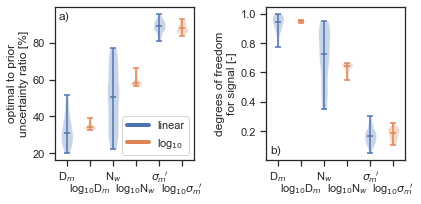

In [29]:

fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(6,3))
positions = np.array([0,2,4])
                     


for yy, key in enumerate(resultsOE.keys()):

    thisOE = resultsOE[key].where((resultsOE[key].chi2value < resultsOE[key].chi2critical).all('chi2test'))
    
    dat = (thisOE['x_op_err']/thisOE['x_a_err']).to_pandas().dropna() * 100
    try: #Different Matplotlib versions handle this differently
        ax1.violinplot(dat, positions = positions+yy, showmedians=True)
    except ValueError:
        ax1.violinplot(dat.T, positions = positions+yy, showmedians=True)

    dat = (thisOE['dgf_x']).to_pandas().dropna()
    try: #Different Matplotlib versions handle this differently
        ax2.violinplot(dat, positions = positions+yy, showmedians=True)
    except ValueError:
        ax2.violinplot(dat.T, positions = positions+yy, showmedians=True)

    
cols = ['Dm', 'Dm_log10', 'Nw', 'Nw_log10', 'Smprime', 'Smprime_log10']
labels = []
for tt in cols:
    labels.append(supporting_routines.niceKeys[tt].replace('log','\nlog'))
ax2.set_xticks(range(6)) 
ax2.set_xticklabels(labels) 
ax1.set_xticks(range(6)) 
ax1.set_xticklabels(labels) 

ax1.set_ylabel('optimal to prior\nuncertainty ratio [%]')
ax2.set_ylabel('degrees of freedom\nfor signal [-]')

custom_lines = [matplotlib.lines.Line2D([0], [0], color='C0', lw=4),
                matplotlib.lines.Line2D([0], [0], color='C1', lw=4),
               ]

ax1.legend(custom_lines, ['linear', 'log$_{10}$'], loc='lower right')
ax1.text(0.03, 0.97, 'a)', horizontalalignment='left', verticalalignment='top', transform = ax1.transAxes)
ax2.text(0.03, 0.03, 'b)', horizontalalignment='left', verticalalignment='bottom', transform = ax2.transAxes)

plt.tight_layout()
plt.savefig('Figure4.png', dpi=200)
plt.savefig('Figure4.pdf')


Interestingly, the median values of the optimal to prior uncertainty ratio distribution are lower for the linear state variables indicating that the linear retrieval version is in general underestimating retrieval uncertainties. At the same time, *d* can be greatly overestimated for individual profiles. 

# References

Mech, M., M. Maahn, S. Kneifel, D. Ori, E. Orlandi, P. Kollias, V. Schemann, and S. Crewell, 2020: PAMTRA 1.0: A Passive and Active Microwave radiative TRAnsfer tool for simulating radiometer and radar measurements of the cloudy atmosphere. Geoscientific Model Development Discussions, 1–34, doi:https://doi.org/10.5194/gmd-2019-356.

Testud, J., S. Oury, R. A. Black, P. Amayenc, and X. Dou, 2001: The concept of normalized distribution to describe raindrop spectra: A tool for cloud physics and cloud remote sensing. *J. Appl. Meteorol.*, 40, 1118–1140, [https://doi.org/10.1175/1520-0450(2001)040<1118:TCONDT>2.0.CO;2](https://doi.org/10.1175/1520-0450(2001)040<1118:TCONDT>2.0.CO;2).

Williams, C. R., V. N. Bringi, L. D. Carey, V. Chandrasekar, P. N. Gatlin, Z. S. Haddad, R. Meneghini, S. Joseph Munchak, S. W. Nesbitt, W. A. Petersen, S. Tanelli, A. Tokay, A. Wilson, and D. B. Wolff, 2014: Describing the Shape of Raindrop Size Distributions Using Uncorrelated Raindrop Mass Spectrum Parameters. *J. Appl. Meteor. Climatol.*, 53, 1282–1296, https://doi.org/10.1175/JAMC-D-13-076.1.


